In [1]:
from lmfit import minimize, Parameters, Parameter, report_fit
import numpy as np
import glob,os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
import re
from tqdm import tqdm
import scipy.stats as st
from os.path import expanduser
import cmath
import scipy.optimize as op
import time
import gzip
import pandas as pd
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,inset_axes,InsetPosition) 
%matplotlib inline

In [2]:
home = os.path.expanduser("~")

In [3]:
# Path to the larger dataset
home = os.path.expanduser("~")

temp = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/alldclc/'
direc = os.listdir(temp)

In [4]:
def empty(df):
    return len(df.index) == 0

def PSPL_data (params, t, A_data):
    
    t0 = params['t0'].value
    tE = params['tE'].value
    u0 = params['u0'].value
    u = np.sqrt(u0**2+((t-t0)/tE)**2)
    A = ((u**2)+2)/(u*np.sqrt(u**2+4))
    return A - A_data

def PSPL (t0, tE, u0, t):
    
    u = np.sqrt(u0**2+((t-t0)/tE)**2)
    A = ((u**2)+2)/(u*np.sqrt(u**2+4))
    return A
        
def PSPL_Gaussian (mean, sigma,amp, t0,u0,tE, t):
    u = np.sqrt(u0**2+((t-t0)/tE)**2)
    A = (((amp/np.sqrt(2*pi*(sigma**2)))*np.exp(-((t-mean)**2)/(2*(sigma**2)))))+((u**2)+2)/(u*np.sqrt((u**2)+4))
    return A

def PSPL_Gaussian_data (params, t, A_data):
    
    t0 = params['t0'].value
    tE = params['tE'].value
    u0 = params['u0'].value
    tp = params['tp'].value
    tEp = params['tEp'].value
    amp = params['amp'].value
    
    u = np.sqrt(u0**2+((t-t0)/tE)**2)
    A = (((amp/np.sqrt(2*pi*(tEp**2)))*np.exp(-((t-tp)**2)/(2*(tEp**2)))))+((u**2)+2)/(u*np.sqrt((u**2)+4))
    
    return A

def lnlike(theta, t, f, f_err):
    t0, u0, tE = theta
    model = fun(t, t0, u0, tE)
    inv_sigma2 = 1.0/(f_err**2)
    return -0.5*(np.sum((f-model)**2*inv_sigma2))

def lnlike2(theta, t, f, f_err):
    mean, sigma,amp, t0,u0,tE = theta
    model = fun2(t,mean, sigma,amp, t0,u0,tE)
    inv_sigma2 = 1.0/(f_err**2)
    return -0.5*(np.sum((f-model)**2*inv_sigma2))

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def calc_chisq2(lightcurve,fx,ferror):
    """Function to calculate the chi squared of the fit of the lightcurve
    data to the function provided"""

    chisq = ((lightcurve - fx)**2 / (ferror**2)).sum()

    return chisq

In [5]:
def localize_event(lightcurve,t0,tE):
    """Function to estimate roughly the area around the peak of an event, 
    and identify which timestamps in the array belong to the event versus
    the baseline
    """
    
    idx1 = np.where(lightcurve >= t0-tE)[0]
    idx2 = np.where(lightcurve <= t0+tE)[0]
    event = list(set(idx1).intersection(set(idx2)))
    
    baseline = np.arange(0,len(lightcurve),1)
    baseline = np.delete(baseline,event)
    
    it0 = np.where(lightcurve == t0)[0][0]
    
    #print min(lightcurve)
    #print it0
    return baseline, event, it0

In [6]:
def prepare(t,m,err):
    
    df = pd.DataFrame({'t': t, 'magnitude': m, 'm_err': err})
    peaks = np.array([t[np.argmin(m)]])
    baseline, event, it0 = localize_event(df['t'], peaks[0],50)
    
    base_mag = np.median(df['magnitude'][baseline])
    df['A'] = 10 ** (0.4*(base_mag - df['magnitude']))
    
    interpol = interp1d(df['t'],df['A'], kind='cubic')
    dt = np.abs(df['t'][np.argmin(np.abs(interpol(df['t'])-1.06))]-peaks[0])
    #print dt
    
    if dt==0.0:
        dt = 50


        
    
    #dt = 50
    baseline, event, it0 = localize_event(df['t'], peaks[0],dt)

    while (np.abs((df['t'][event]).diff())).max() > 0.1:
        
        if dt>20:
            dt = dt - 10
            baseline, event, it0 = localize_event(df['t'], peaks[0],dt)
        else:
            break
    #print dt    
    return df, baseline, event, it0, dt





In [7]:
# Reading in one single lightcurve from the small sample of data challenge light curves

f = '/mag.dcnormffp_0_82_3.det.lc.W149' #non-binary

t,m,e = np.loadtxt(temp+f,unpack=True)



In [8]:
df, baseline, event, it0, dt = prepare(t,m,e)

In [10]:
A_max = df['A'][np.argmin(m[m>np.percentile(m, [0.01,100])[0]])] #np.max(df['A']) #1.0/(float(f_s_true)/(max(df['f'])-1+float(f_s_true)))
u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
t0_true = df['t'][np.argmin(m[m>np.percentile(m, [0.01,100])[0]])] #it0 #t[A.argmax()] #float(t0_theo)
print (t0_true)

2460007.99237


(2460002.9923680001, 2460012.9923680001)

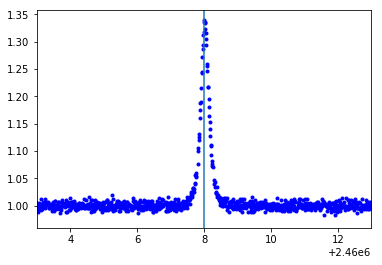

In [20]:
plt.plot(df['t'], df['A'],'b.')
plt.axvline(t0_true)
plt.xlim(t0_true-5, t0_true+5)

In [12]:

#ind1, ind2 = fwhm(A,A.argmax(),1)
#tE_true = t[ind2]-t[ind1]
tE_true = 10 #[tE_finder (t,A),t[ind2]-t[ind1]]
#print 'tE_true = '+ str( tE_true)

params = Parameters()
params.add('t0', value= t0_true, min=min(df['t']), max=max(df['t']))
params.add('tE', value= tE_true, min=0.001, max=1000)
params.add('u0', value= u0_true, min=0, max=5)

result = minimize(PSPL_data, params, args=(df['t'].values, df['A'].values))



In [13]:
params

name,value,initial value,min,max,vary
t0,2460007.99,2460007.99237,2458346.51,2460059.24,True
tE,10.0000000,10,1.0000e-03,1000.00000,True
u0,0.63949039,0.639490390277,0.00000000,5.00000000,True


In [14]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
t0,2460008.01,6.9976e-04,0.00%,2460007.99237,2458346.51,2460059.24,True
tE,0.14545696,8.8334e-04,0.61%,10,1.0000e-03,1000.00000,True
u0,1.00843121,0.00248686,0.25%,0.639490390277,0.00000000,5.00000000,True


In [15]:
result

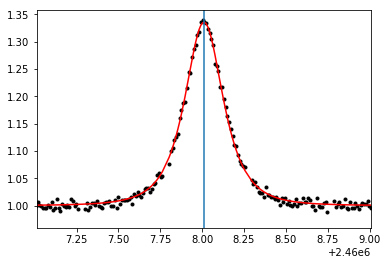

In [23]:
dt = 1

xplot = np.linspace(min(df['t'].values), max(df['t'].values), 1000)
yplot = PSPL(result.params['t0'],result.params['tE'],result.params['u0'], df['t'])
#plot results

import pylab
pylab.plot(df['t'], df['A'], 'k.')
pylab.plot(df['t'], yplot, 'r')
plt.axvline(result.params['t0'])
plt.xlim(result.params['t0'].value-dt, result.params['t0'].value+dt)
pylab.show()


In [16]:
def PSPL_lm_fitter (t, A, error):
    
    df, baseline, event, it0, dt = prepare(t,m,e)
    
    A_max = df['A'][np.argmin(m[m>np.percentile(m, [0.01,100])[0]])] #np.max(df['A']) #1.0/(float(f_s_true)/(max(df['f'])-1+float(f_s_true)))
    u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
    t0_true =  df['t'][np.argmin(m[m>np.percentile(m, [0.01,100])[0]])] #it0 #t[A.argmax()] #float(t0_theo)

    tE_true = 10

    params = Parameters()
    params.add('t0', value= t0_true, min=min(df['t']), max=max(df['t']))
    params.add('tE', value= tE_true, min=0.001, max=1000)
    params.add('u0', value= u0_true, min=0, max=5)

    result = minimize(PSPL_data, params, args=(df['t'].values, df['A'].values))
    
    return result.params['t0'].value, result.params['tE'].value, result.params['u0'].value, result.chisqr
    

In [143]:
# Trying it on all light curves of the large sample of data challenge light curves

direc.sort()
result_n = {'name':[], 't':[], 'A':[], 'event':[], 't0':[], 'tE':[],'u0':[], 'chisqr':[], 'reduced_chisqr_ratio': []}
for f in tqdm(direc):
    #print f
    
    if f.endswith('.W149') and f.startswith('mag.'):
        #print f
        
        try:
            t,m,e = np.loadtxt(temp+str(f),unpack=True)
            df, baseline, event, it0, dt = prepare(t,m,e)

            t0, tE, u0, chisqr = PSPL_lm_fitter(df['t'].values, df['A'].values, df['m_err'].values)       

            right = (np.sum((df['A'][(df.t > t0) ]-PSPL(t0,tE,u0, df['t'][df.t > t0]))**2))/float(len(df['t'])-3)
            left = (np.sum((df['A'][(df.t < t0) ]-PSPL(t0,tE,u0, df['t'][df.t < t0]))**2))/float(len(df['t'])-3)
            
            reduced_chisqr_ratio = left/right
            
            result_n['name'].append(f)
            result_n['t'].append(t)
            result_n['A'].append(df['A'].values)
            result_n['event'].append(event)
            result_n['t0'].append(t0)
            result_n['tE'].append(tE)
            result_n['u0'].append(u0)
            result_n['chisqr'].append(chisqr)
            result_n['reduced_chisqr_ratio'].append(reduced_chisqr_ratio)
        
        except (RuntimeError, TypeError, NameError, ValueError):
            
            #print f
            pass
        


print 'done'

100%|██████████| 9948/9948 [1:48:50<00:00,  1.52it/s]

done


In [18]:
len(result_n['name'])

4648

In [19]:
info1 = pd.read_csv('ombin.CSV')
info2 = pd.read_csv('omcassan.CSV')
info3 = pd.read_csv('dccv.CSV')
info4 = pd.read_csv('dcnormffp.CSV')

In [20]:
frames = [info1, info2, info3, info4]

info = pd.concat(frames)

In [21]:
info['t0_exp'] = np.zeros(len(info))
info['tE_exp'] = np.zeros(len(info))
info['u0_exp'] = np.zeros(len(info))
info['chisqr'] = np.zeros(len(info))
# info['f0_exp'] = np.zeros(len(info))
# info['min_chi_sqr'] = np.zeros(len(info))
# info['chi_sqr_base'] = np.zeros(len(info))
# info['chi_sqr_right'] = np.zeros(len(info))
# info['chi_sqr_left'] = np.zeros(len(info))

In [22]:
info = info.rename(columns={"index": "name"})

In [24]:
for i in range(len(result_n['name'])):

    if result_n['name'][i].split('.lc')[0].endswith('all'): 
        result_n['name'][i] = result_n['name'][i].split('all')[0]+'det'+result_n['name'][i].split('all')[1]

In [25]:

for i in tqdm(range(len(result_n['name']))):
     
    
    info.loc[info.name == result_n['name'][i], 't0_exp'] = result_n['t0'][i]
    info.loc[info.name == result_n['name'][i], 'tE_exp'] = result_n['tE'][i]
    info.loc[info.name == result_n['name'][i], 'u0_exp'] = result_n['u0'][i]
    info.loc[info.name == result_n['name'][i], 'chisqr'] = result_n['chisqr'][i]
#     info.loc[info.name == result['name'][i], 'f0_exp'] = result['f0_exp'][i]
#     info.loc[info.name == result['name'][i], 'min_chi_sqr'] = result['min_chi_sqr'][i]
#     info.loc[info.name == result['name'][i], 'chi_sqr_base'] = result['chi_sqr_base'][i]
#     info.loc[info.name == result['name'][i], 'chi_sqr_right'] = result['chi_sqr_right'][i]
#     info.loc[info.name == result['name'][i], 'chi_sqr_left'] = result['chi_sqr_left'][i]



    
    if not result_n['name'][i] in info.name.values:
        print result_n['name'][i]

 79%|███████▉  | 3685/4648 [01:00<00:15, 60.80it/s]

mag.omcassan_0_100_1197.det.lc.W149
mag.omcassan_0_100_3114.det.lc.W149
mag.omcassan_0_100_66.det.lc.W149
mag.omcassan_0_10_1228.det.lc.W149


 80%|███████▉  | 3713/4648 [01:01<00:15, 60.83it/s]

mag.omcassan_0_21_2040.det.lc.W149
mag.omcassan_0_21_414.det.lc.W149
mag.omcassan_0_22_3213.det.lc.W149


 80%|████████  | 3727/4648 [01:01<00:15, 60.83it/s]

mag.omcassan_0_34_1491.det.lc.W149
mag.omcassan_0_35_2018.det.lc.W149
mag.omcassan_0_44_669.det.lc.W149
mag.omcassan_0_46_400.det.lc.W149


 80%|████████  | 3741/4648 [01:01<00:14, 60.85it/s]

mag.omcassan_0_48_1719.det.lc.W149
mag.omcassan_0_49_1633.det.lc.W149
mag.omcassan_0_58_1019.det.lc.W149
mag.omcassan_0_59_1633.det.lc.W149
mag.omcassan_0_59_2013.det.lc.W149
mag.omcassan_0_61_1201.det.lc.W149
mag.omcassan_0_61_384.det.lc.W149


 81%|████████  | 3755/4648 [01:01<00:14, 60.86it/s]

mag.omcassan_0_61_681.det.lc.W149
mag.omcassan_0_63_316.det.lc.W149
mag.omcassan_0_6_1191.det.lc.W149
mag.omcassan_0_71_259.det.lc.W149


 81%|████████  | 3776/4648 [01:02<00:14, 60.88it/s]

mag.omcassan_0_7_534.det.lc.W149
mag.omcassan_0_83_241.det.lc.W149
mag.omcassan_0_84_720.det.lc.W149
mag.omcassan_0_86_2143.det.lc.W149
mag.omcassan_0_86_2152.det.lc.W149
mag.omcassan_0_87_1718.det.lc.W149
mag.omcassan_0_87_2127.det.lc.W149


 82%|████████▏ | 3790/4648 [01:02<00:14, 60.89it/s]

mag.omcassan_0_88_2050.det.lc.W149
mag.omcassan_0_89_114.det.lc.W149
mag.omcassan_0_97_1005.det.lc.W149
mag.omcassan_0_97_964.det.lc.W149
mag.omcassan_0_98_1251.det.lc.W149
mag.omcassan_0_98_1412.det.lc.W149
mag.omcassan_0_99_1601.det.lc.W149


 82%|████████▏ | 3811/4648 [01:02<00:13, 60.90it/s]

mag.omcassan_10_18_463.det.lc.W149
mag.omcassan_10_44_787.det.lc.W149
mag.omcassan_10_47_126.det.lc.W149
mag.omcassan_10_50_253.det.lc.W149
mag.omcassan_10_5_594.det.lc.W149


 82%|████████▏ | 3825/4648 [01:02<00:13, 60.90it/s]

mag.omcassan_10_6_423.det.lc.W149
mag.omcassan_10_72_1307.det.lc.W149
mag.omcassan_10_73_847.det.lc.W149
mag.omcassan_10_89_385.det.lc.W149
mag.omcassan_10_98_148.det.lc.W149


 83%|████████▎ | 3846/4648 [01:03<00:13, 60.92it/s]

mag.omcassan_1_110_551.det.lc.W149
mag.omcassan_1_111_474.det.lc.W149
mag.omcassan_1_112_1070.det.lc.W149
mag.omcassan_1_112_65.det.lc.W149
mag.omcassan_1_113_1809.det.lc.W149


 83%|████████▎ | 3860/4648 [01:03<00:12, 60.93it/s]

mag.omcassan_1_11_182.det.lc.W149
mag.omcassan_1_18_442.det.lc.W149
mag.omcassan_1_18_674.det.lc.W149
mag.omcassan_1_20_288.det.lc.W149
mag.omcassan_1_20_979.det.lc.W149
mag.omcassan_1_23_1262.det.lc.W149
mag.omcassan_1_23_1397.det.lc.W149
mag.omcassan_1_23_990.det.lc.W149


 83%|████████▎ | 3874/4648 [01:03<00:12, 60.94it/s]

mag.omcassan_1_31_529.det.lc.W149
mag.omcassan_1_48_1401.det.lc.W149


 84%|████████▎ | 3888/4648 [01:03<00:12, 60.96it/s]

mag.omcassan_1_57_2109.det.lc.W149
mag.omcassan_1_5_2403.det.lc.W149
mag.omcassan_1_5_2609.det.lc.W149
mag.omcassan_1_60_992.det.lc.W149
mag.omcassan_1_62_1260.det.lc.W149
mag.omcassan_1_63_1559.det.lc.W149


 84%|████████▍ | 3909/4648 [01:04<00:12, 60.97it/s]

mag.omcassan_1_70_1516.det.lc.W149
mag.omcassan_1_73_1372.det.lc.W149
mag.omcassan_1_75_1206.det.lc.W149
mag.omcassan_1_75_250.det.lc.W149


 85%|████████▍ | 3930/4648 [01:04<00:11, 60.99it/s]

mag.omcassan_1_84_1418.det.lc.W149
mag.omcassan_1_89_1387.det.lc.W149
mag.omcassan_1_89_1625.det.lc.W149
mag.omcassan_1_89_565.det.lc.W149
mag.omcassan_1_98_479.det.lc.W149


 85%|████████▌ | 3951/4648 [01:04<00:11, 61.00it/s]

mag.omcassan_2_10_214.det.lc.W149
mag.omcassan_2_110_1013.det.lc.W149
mag.omcassan_2_110_1407.det.lc.W149
mag.omcassan_2_110_2700.det.lc.W149
mag.omcassan_2_112_3277.det.lc.W149
mag.omcassan_2_115_1010.det.lc.W149


 85%|████████▌ | 3965/4648 [01:04<00:11, 61.02it/s]

mag.omcassan_2_20_1425.det.lc.W149
mag.omcassan_2_20_253.det.lc.W149
mag.omcassan_2_24_1036.det.lc.W149
mag.omcassan_2_31_1443.det.lc.W149
mag.omcassan_2_31_37.det.lc.W149
mag.omcassan_2_31_832.det.lc.W149
mag.omcassan_2_33_54.det.lc.W149


 86%|████████▌ | 3986/4648 [01:05<00:10, 61.04it/s]

mag.omcassan_2_50_216.det.lc.W149
mag.omcassan_2_50_726.det.lc.W149
mag.omcassan_2_58_1579.det.lc.W149


 86%|████████▋ | 4014/4648 [01:05<00:10, 61.06it/s]

mag.omcassan_2_76_219.det.lc.W149


 87%|████████▋ | 4021/4648 [01:05<00:10, 61.06it/s]

mag.omcassan_2_87_970.det.lc.W149
mag.omcassan_2_88_1615.det.lc.W149
mag.omcassan_2_96_1919.det.lc.W149
mag.omcassan_2_98_1355.det.lc.W149
mag.omcassan_3_101_1518.det.lc.W149


 87%|████████▋ | 4042/4648 [01:06<00:09, 61.07it/s]

mag.omcassan_3_10_404.det.lc.W149
mag.omcassan_3_10_486.det.lc.W149
mag.omcassan_3_10_628.det.lc.W149
mag.omcassan_3_110_1304.det.lc.W149


 87%|████████▋ | 4056/4648 [01:06<00:09, 61.08it/s]

mag.omcassan_3_11_2077.det.lc.W149
mag.omcassan_3_11_3148.det.lc.W149
mag.omcassan_3_18_3023.det.lc.W149
mag.omcassan_3_20_1560.det.lc.W149
mag.omcassan_3_20_1641.det.lc.W149


 88%|████████▊ | 4070/4648 [01:06<00:09, 61.10it/s]

mag.omcassan_3_21_3178.det.lc.W149
mag.omcassan_3_24_1912.det.lc.W149
mag.omcassan_3_31_677.det.lc.W149
mag.omcassan_3_33_976.det.lc.W149


 88%|████████▊ | 4091/4648 [01:06<00:09, 61.12it/s]

mag.omcassan_3_49_397.det.lc.W149
mag.omcassan_3_60_1155.det.lc.W149
mag.omcassan_3_60_610.det.lc.W149
mag.omcassan_3_61_1090.det.lc.W149


 88%|████████▊ | 4105/4648 [01:07<00:08, 61.13it/s]

mag.omcassan_3_70_2948.det.lc.W149
mag.omcassan_3_72_1843.det.lc.W149
mag.omcassan_3_72_2269.det.lc.W149


 89%|████████▊ | 4119/4648 [01:07<00:08, 61.15it/s]

mag.omcassan_3_75_2250.det.lc.W149
mag.omcassan_3_76_472.det.lc.W149
mag.omcassan_3_83_382.det.lc.W149
mag.omcassan_3_84_119.det.lc.W149
mag.omcassan_3_86_862.det.lc.W149


 89%|████████▉ | 4133/4648 [01:07<00:08, 61.16it/s]

mag.omcassan_3_87_49.det.lc.W149
mag.omcassan_3_89_51.det.lc.W149
mag.omcassan_3_89_57.det.lc.W149
mag.omcassan_3_96_1862.det.lc.W149
mag.omcassan_3_97_694.det.lc.W149


 89%|████████▉ | 4154/4648 [01:07<00:08, 61.18it/s]

mag.omcassan_3_9_165.det.lc.W149
mag.omcassan_4_100_282.det.lc.W149
mag.omcassan_4_100_393.det.lc.W149
mag.omcassan_4_102_2853.det.lc.W149
mag.omcassan_4_102_369.det.lc.W149


 90%|████████▉ | 4168/4648 [01:08<00:07, 61.19it/s]

mag.omcassan_4_111_506.det.lc.W149
mag.omcassan_4_112_1245.det.lc.W149
mag.omcassan_4_112_585.det.lc.W149
mag.omcassan_4_115_3069.det.lc.W149


 90%|████████▉ | 4182/4648 [01:08<00:07, 61.19it/s]

mag.omcassan_4_115_510.det.lc.W149
mag.omcassan_4_18_1719.det.lc.W149
mag.omcassan_4_20_1994.det.lc.W149


 90%|█████████ | 4196/4648 [01:08<00:07, 61.21it/s]

mag.omcassan_4_22_1056.det.lc.W149
mag.omcassan_4_22_117.det.lc.W149
mag.omcassan_4_32_2432.det.lc.W149
mag.omcassan_4_32_2978.det.lc.W149
mag.omcassan_4_34_1702.det.lc.W149


 91%|█████████ | 4210/4648 [01:08<00:07, 61.22it/s]

mag.omcassan_4_35_120.det.lc.W149
mag.omcassan_4_36_1502.det.lc.W149
mag.omcassan_4_45_2664.det.lc.W149
mag.omcassan_4_46_1589.det.lc.W149
mag.omcassan_4_48_1128.det.lc.W149
mag.omcassan_4_48_41.det.lc.W149
mag.omcassan_4_49_18.det.lc.W149


 91%|█████████ | 4224/4648 [01:08<00:06, 61.22it/s]

mag.omcassan_4_50_713.det.lc.W149
mag.omcassan_4_57_3017.det.lc.W149
mag.omcassan_4_58_965.det.lc.W149
mag.omcassan_4_59_1960.det.lc.W149


 91%|█████████ | 4238/4648 [01:09<00:06, 61.22it/s]

mag.omcassan_4_5_2136.det.lc.W149
mag.omcassan_4_5_2998.det.lc.W149
mag.omcassan_4_5_3035.det.lc.W149
mag.omcassan_4_61_1408.det.lc.W149
mag.omcassan_4_61_1697.det.lc.W149
mag.omcassan_4_61_418.det.lc.W149


 91%|█████████▏| 4252/4648 [01:09<00:06, 61.24it/s]

mag.omcassan_4_71_388.det.lc.W149
mag.omcassan_4_76_1183.det.lc.W149
mag.omcassan_4_7_1120.det.lc.W149
mag.omcassan_4_7_1389.det.lc.W149
mag.omcassan_4_7_2334.det.lc.W149
mag.omcassan_4_85_882.det.lc.W149


 92%|█████████▏| 4266/4648 [01:09<00:06, 61.26it/s]

mag.omcassan_4_86_3148.det.lc.W149
mag.omcassan_4_88_147.det.lc.W149
mag.omcassan_4_89_26.det.lc.W149


 92%|█████████▏| 4280/4648 [01:09<00:06, 61.23it/s]

mag.omcassan_4_98_2078.det.lc.W149
mag.omcassan_4_99_747.det.lc.W149


 92%|█████████▏| 4294/4648 [01:10<00:05, 61.23it/s]

mag.omcassan_5_109_1444.det.lc.W149
mag.omcassan_5_115_1345.det.lc.W149


 93%|█████████▎| 4322/4648 [01:10<00:05, 61.26it/s]

mag.omcassan_5_20_827.det.lc.W149
mag.omcassan_5_22_702.det.lc.W149
mag.omcassan_5_24_2829.det.lc.W149
mag.omcassan_5_31_1788.det.lc.W149
mag.omcassan_5_32_2780.det.lc.W149


 93%|█████████▎| 4336/4648 [01:10<00:05, 61.27it/s]

mag.omcassan_5_32_901.det.lc.W149
mag.omcassan_5_33_1030.det.lc.W149
mag.omcassan_5_33_2063.det.lc.W149
mag.omcassan_5_33_494.det.lc.W149
mag.omcassan_5_35_1368.det.lc.W149
mag.omcassan_5_36_594.det.lc.W149


 94%|█████████▎| 4350/4648 [01:10<00:04, 61.28it/s]

mag.omcassan_5_48_2673.det.lc.W149
mag.omcassan_5_58_943.det.lc.W149
mag.omcassan_5_59_364.det.lc.W149
mag.omcassan_5_59_423.det.lc.W149


 94%|█████████▍| 4364/4648 [01:11<00:04, 61.28it/s]

mag.omcassan_5_59_58.det.lc.W149
mag.omcassan_5_63_1267.det.lc.W149
mag.omcassan_5_70_1893.det.lc.W149


 94%|█████████▍| 4378/4648 [01:11<00:04, 61.29it/s]

mag.omcassan_5_72_771.det.lc.W149
mag.omcassan_5_73_1293.det.lc.W149
mag.omcassan_5_76_1362.det.lc.W149
mag.omcassan_5_86_510.det.lc.W149


 94%|█████████▍| 4392/4648 [01:11<00:04, 61.30it/s]

mag.omcassan_5_96_2508.det.lc.W149
mag.omcassan_5_98_680.det.lc.W149
mag.omcassan_6_100_449.det.lc.W149
mag.omcassan_6_101_674.det.lc.W149
mag.omcassan_6_109_1439.det.lc.W149


 95%|█████████▍| 4406/4648 [01:11<00:03, 61.32it/s]

mag.omcassan_6_110_1017.det.lc.W149
mag.omcassan_6_113_876.det.lc.W149
mag.omcassan_6_18_778.det.lc.W149
mag.omcassan_6_19_780.det.lc.W149
mag.omcassan_6_21_1422.det.lc.W149
mag.omcassan_6_22_143.det.lc.W149


 95%|█████████▌| 4427/4648 [01:12<00:03, 61.33it/s]

mag.omcassan_6_31_1211.det.lc.W149
mag.omcassan_6_32_1161.det.lc.W149
mag.omcassan_6_37_515.det.lc.W149
mag.omcassan_6_44_718.det.lc.W149
mag.omcassan_6_48_1044.det.lc.W149


 95%|█████████▌| 4434/4648 [01:12<00:03, 61.33it/s]

mag.omcassan_6_48_138.det.lc.W149
mag.omcassan_6_61_1145.det.lc.W149
mag.omcassan_6_63_275.det.lc.W149
mag.omcassan_6_6_1121.det.lc.W149
mag.omcassan_6_6_1314.det.lc.W149


 96%|█████████▌| 4455/4648 [01:12<00:03, 61.34it/s]

mag.omcassan_6_71_1009.det.lc.W149
mag.omcassan_6_73_1158.det.lc.W149
mag.omcassan_6_74_46.det.lc.W149
mag.omcassan_6_74_69.det.lc.W149
mag.omcassan_6_83_728.det.lc.W149


 96%|█████████▌| 4469/4648 [01:12<00:02, 61.34it/s]

mag.omcassan_6_9_342.det.lc.W149
mag.omcassan_6_9_665.det.lc.W149
mag.omcassan_7_109_476.det.lc.W149
mag.omcassan_7_10_1028.det.lc.W149
mag.omcassan_7_110_397.det.lc.W149


 97%|█████████▋| 4490/4648 [01:13<00:02, 61.35it/s]

mag.omcassan_7_18_1025.det.lc.W149
mag.omcassan_7_18_1395.det.lc.W149
mag.omcassan_7_19_321.det.lc.W149


 97%|█████████▋| 4511/4648 [01:13<00:02, 61.37it/s]

mag.omcassan_7_35_1480.det.lc.W149
mag.omcassan_7_35_1849.det.lc.W149
mag.omcassan_7_45_1506.det.lc.W149
mag.omcassan_7_46_132.det.lc.W149
mag.omcassan_7_47_674.det.lc.W149


 98%|█████████▊| 4532/4648 [01:13<00:01, 61.37it/s]

mag.omcassan_7_61_349.det.lc.W149
mag.omcassan_7_6_217.det.lc.W149
mag.omcassan_7_70_805.det.lc.W149
mag.omcassan_7_76_1006.det.lc.W149


 98%|█████████▊| 4546/4648 [01:14<00:01, 61.38it/s]

mag.omcassan_7_86_1057.det.lc.W149
mag.omcassan_8_111_1331.det.lc.W149
mag.omcassan_8_112_591.det.lc.W149
mag.omcassan_8_11_1083.det.lc.W149
mag.omcassan_8_11_432.det.lc.W149


 98%|█████████▊| 4560/4648 [01:14<00:01, 61.39it/s]

mag.omcassan_8_20_529.det.lc.W149
mag.omcassan_8_23_988.det.lc.W149
mag.omcassan_8_24_844.det.lc.W149
mag.omcassan_8_24_947.det.lc.W149
mag.omcassan_8_36_245.det.lc.W149


 98%|█████████▊| 4574/4648 [01:14<00:01, 61.39it/s]

mag.omcassan_8_50_222.det.lc.W149
mag.omcassan_8_61_714.det.lc.W149
mag.omcassan_8_75_1283.det.lc.W149


 99%|█████████▉| 4595/4648 [01:14<00:00, 61.40it/s]

mag.omcassan_8_83_234.det.lc.W149
mag.omcassan_8_8_1306.det.lc.W149
mag.omcassan_8_96_617.det.lc.W149
mag.omcassan_9_100_1029.det.lc.W149
mag.omcassan_9_109_347.det.lc.W149
mag.omcassan_9_110_116.det.lc.W149


 99%|█████████▉| 4609/4648 [01:15<00:00, 61.41it/s]

mag.omcassan_9_112_145.det.lc.W149
mag.omcassan_9_24_504.det.lc.W149
mag.omcassan_9_24_563.det.lc.W149
mag.omcassan_9_31_743.det.lc.W149


100%|█████████▉| 4630/4648 [01:15<00:00, 61.43it/s]

mag.omcassan_9_46_840.det.lc.W149
mag.omcassan_9_59_130.det.lc.W149
mag.omcassan_9_5_426.det.lc.W149
mag.omcassan_9_60_557.det.lc.W149


100%|██████████| 4648/4648 [01:15<00:00, 61.45it/s]

mag.omcassan_9_84_1101.det.lc.W149
mag.omcassan_9_89_499.det.lc.W149
mag.omcassan_9_99_932.det.lc.W149


In [26]:
info = info.reset_index()

In [27]:
info['type'] = np.zeros(len(info))

for i in tqdm(range(len(info))):
    
    if info['name'][i].split('mag')[1].startswith('.ombin'):
        
        info.set_value(i, 'type', 1)
        
    if info['name'][i].split('mag')[1].startswith('.dccv'):
        
        info.set_value(i, 'type', 0)
        
    if info['name'][i].split('mag')[1].startswith('.dcnormffp'):
        
        info.set_value(i, 'type', 3)
        
    if info['name'][i].split('mag')[1].startswith('.omcassan'):
        
        info.set_value(i, 'type', 2)

 26%|██▌       | 1222/4769 [00:00<00:00, 12212.32it/s]/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
100%|██████████| 4769/4769 [00:00<00:00, 13099.96it/s]


In [56]:
info['t0_exp'] = info.t0_exp - 2458234

In [80]:
info = info[np.abs((info.t0_exp)-(info.t0))<10]

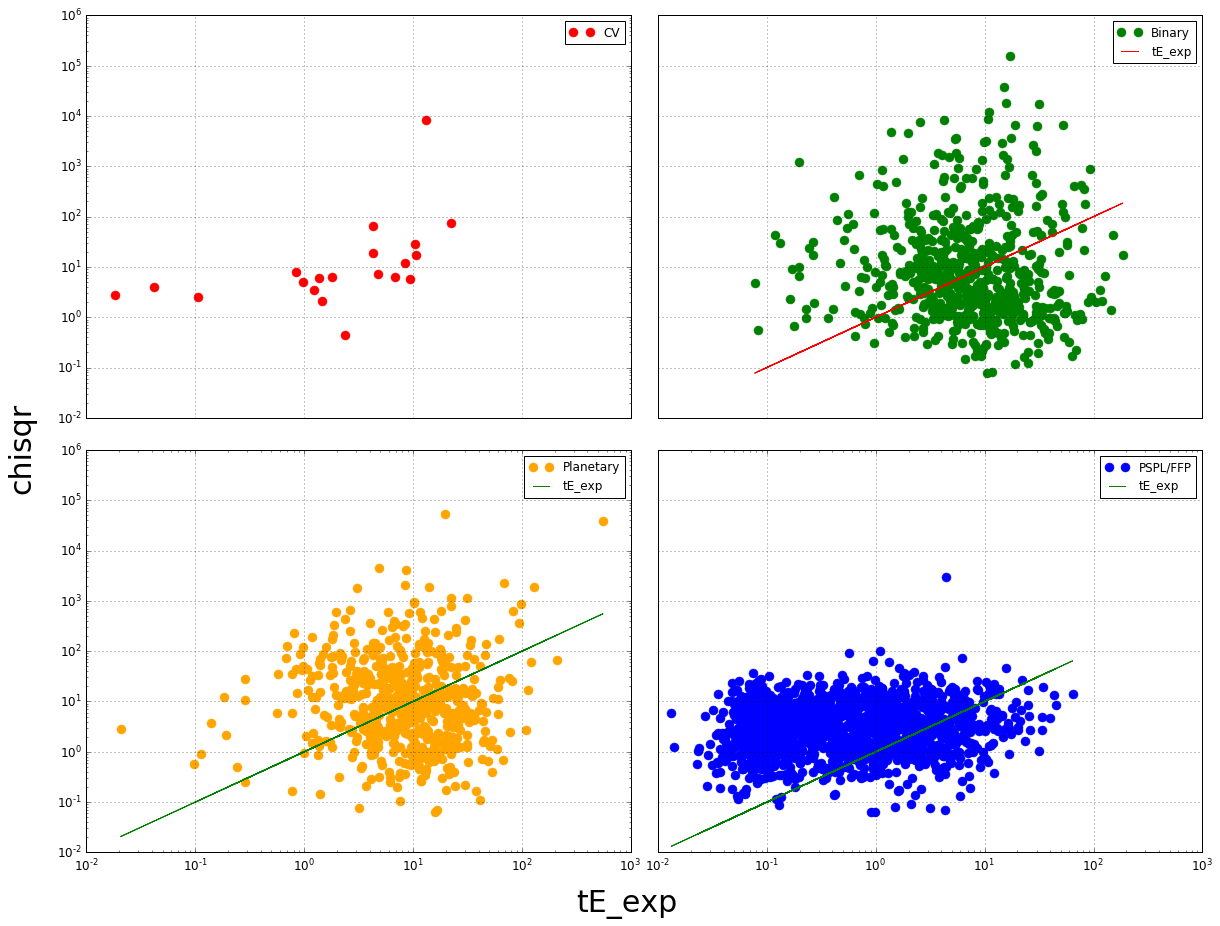

In [90]:
# General format for plotting different parameters versus each other 

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

x = 'tE_exp'
y = 'chisqr'
c = 1

axs[0,0].plot((info[x][info['type']==0]).astype(float).abs(),c*(info[y][info['type']==0]).astype(float).abs(), '.',markersize=18, label= 'CV',color='r')
axs[0,0].grid()
axs[0,0].legend()
axs[0,1].plot((info[x][info['type']==1]).astype(float).abs(),c*(info[y][info['type']==1]).astype(float).abs(), '.',markersize=18, label= 'Binary', color='g')
axs[0,1].plot((info[x][info['type']==1]).astype(float).abs(),(info[x][info['type']==1]).astype(float).abs(), 'r-')
axs[0,1].grid()
axs[0,1].legend()
axs[1,0].plot((info[x][info['type']==2]).astype(float).abs(),c*(info[y][info['type']==2]).astype(float).abs(), '.',markersize=18, label= 'Planetary',  color = 'orange')
axs[1,0].plot((info[x][info['type']==2]).astype(float).abs(),(info[x][info['type']==2]).astype(float).abs(), 'g-')
axs[1,0].grid()
axs[1,0].legend()
axs[1,1].plot((info[x][info['type']==3]).astype(float).abs(),c*(info[y][info['type']==3]).astype(float).abs(), '.',markersize=18, label= 'PSPL/FFP', color='blue')
axs[1,1].plot((info[x][info['type']==3]).astype(float).abs(),(info[x][info['type']==3]).astype(float).abs(), 'g-')
axs[1,1].grid()
axs[1,1].legend()


axs[0, 1].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
axs[0, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off',length=0)

axs[0, 0].tick_params(axis='y',which='both', labelsize=12)
axs[1, 0].tick_params(axis='both',which='both', labelsize=12)
axs[1, 1].tick_params(axis='x',which='both', labelsize=12)

plt.yscale('log')
plt.xscale('log')



axs[0, 0].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
axs[1, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off', length=0)

xlim = (0,0.1)
ylim = (0,2)

# axs[0,0].set_ylim(ylim)
# axs[0,0].set_xlim(xlim)
# axs[0,1].set_ylim(ylim)
# axs[0,1].set_xlim(xlim)
# axs[1,0].set_ylim(ylim)
# axs[1,0].set_xlim(xlim)
# axs[1,1].set_ylim(ylim)
# axs[1,1].set_xlim(xlim)

#axs[0,0].set_xscale('log')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.05, hspace=0.08) 

fig.text(0.5, 0.07, x, ha='center',size=30)
fig.text(0.07, 0.5, y, va='center', rotation='vertical',size=30)

fig = plt.gcf()
fig.set_size_inches(20.0,15.0)
#fig.savefig('a4-a2.png')

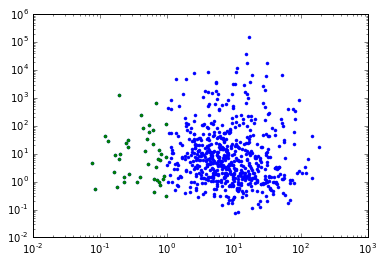

In [86]:
x = 'tE_exp'
# plt.plot(info[x][info.type==0], info['chisqr'][info.type==0],'r.')
plt.plot(info[x][info.type==1], info['chisqr'][info.type==1],'b.')
# plt.plot(info[x][info.type==2], info['chisqr'][info.type==2],'g.')
# plt.plot(info[x][info.type==3], info['chisqr'][info.type==3],'k.')

plt.plot(info[x][(info.type==1)& (info.tE_exp<1)], info['chisqr'][(info.type==1)& (info.tE_exp<1)],'g.')




plt.yscale('log')
plt.xscale('log')




In [107]:
info[['name', 't0', 't0_exp', 'tE', 'tE_exp','u0']][(info.type==1)& (info.chisqr<10)]

,name,t0,t0_exp,tE,tE_exp,u0
2,mag.ombin_0_0_60.det.lc.W149,169.019466,176.358484,7.50919,1.207512,2.967330
3,mag.ombin_0_0_132.det.lc.W149,319.655103,325.040223,3.33592,0.710735,0.977095
4,mag.ombin_0_0_140.det.lc.W149,1619.996012,1618.989138,42.96330,35.685233,2.071580
5,mag.ombin_0_0_192.det.lc.W149,332.052409,327.873854,18.52240,15.233037,-0.780478
6,mag.ombin_0_0_203.det.lc.W149,1596.450909,1597.777695,19.87870,21.076187,1.606100
7,mag.ombin_0_0_232.det.lc.W149,1377.841993,1383.947279,12.17630,6.635292,-2.557920
10,mag.ombin_0_0_366.det.lc.W149,1446.730780,1446.729923,10.92700,10.103709,-0.683501
13,mag.ombin_0_1_49.det.lc.W149,1582.142678,1576.031840,7.51422,4.656136,-1.577730
14,mag.ombin_0_1_58.det.lc.W149,311.890669,303.728166,7.21004,5.032805,1.197610
18,mag.ombin_0_1_234.det.lc.W149,1407.159796,1407.465057,40.34530,11.459269,0.246509


In [113]:
t0_ml, u0_ml, tE_ml = result.params['t0'],result.params['tE'],result.params['u0']

f_ris = df['A'] - PSPL(t0_ml, u0_ml, tE_ml, df['t'].values)
    
duration = [0.01,0.1,1]  

f_res = f_ris
f_res = smooth(f_ris,10)



/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  app.launch_new_instance()


(2459973.208736708, 2460073.208736708)

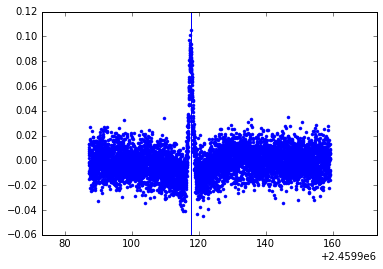

In [159]:
t_ = np.asarray(df['t'].values)
plt.plot(df['t'], f_ris, 'b.')
plt.axvline(t_[f_ris.argmax()])
plt.xlim(result.params['t0'].value-50, result.params['t0'].value+50)



In [ ]:
params2 = Parameters()
params2.add('tp', value= t_[f_ris.argmax()], min=min(df['t']), max=max(df['t']))
params2.add('tEp', value= 1, min=0.00001, max=3)
params2.add('amp', value= f_ris.max()* sigma * np.sqrt(2*pi), min=0.00001, max=5)

result2 = minimize(PSPL_Gaussian_data, params2, args=(df['t'].values, df['A'].values))

In [115]:
f_ris__ = [f_ris.max(),f_ris.min()]
t_ris__ = [t_[f_ris.argmax()],t_[f_ris.argmin()]]


/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  from ipykernel import kernelapp as app
/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  from ipykernel import kernelapp as app


In [157]:
params2 = Parameters()
params2.add('t0', value= result.params['t0'].value, min=min(df['t']), max=max(df['t']))
params2.add('tE', value= 10, min=0.001, max=1000)
params2.add('u0', value= result.params['u0'], min=0, max=5)
params2.add('tp', value= t_[f_ris.argmax()], min=min(df['t']), max=max(df['t']))
params2.add('tEp', value= 1, min=0.00001, max=3)
params2.add('amp', value= f_ris.max()* sigma * np.sqrt(2*pi), min=0.00001, max=5)

result2 = minimize(PSPL_Gaussian_data, params2, args=(df['t'].values, df['A'].values))

/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


In [158]:
result2

In [150]:
min_model_ = [[],[]]

for sigma in duration:

    for a in range(0,2):
        
        
        print t_ris__[a], sigma, f_ris__[a]
        params2 = Parameters()
        params2.add('t0', value= result.params['t0'].value, min=min(df['t']), max=max(df['t']))
        params2.add('tE', value= result.params['tE'].value, min=0.001, max=1000)
        params2.add('u0', value= result.params['u0'], min=0, max=5)
        params2.add('tp', value= t_ris__[a], min=min(df['t']), max=max(df['t']))
        params2.add('tEp', value= sigma, min=0.00001, max=3)
        params2.add('amp', value= f_ris__[a]* sigma * np.sqrt(2*pi), min=0.00001, max=5)

        result2 = minimize(PSPL_Gaussian_data, params2, args=(df['t'].values, df['A'].values))

        min_model_[0].append(result2.chisqr)
        min_model_[1].append([result2.params['t0'],result2.params['tE'],result2.params['u0'],
                             result2.params['tp'],result2.params['tEp'],result2.params['amp']])


min_chisqr = np.asarray( min_model_[0])
best_fit_params= min_model_[1][min_chisqr.argmax()]  

2460017.644856 0.01 0.10527106061900526
2460021.315707 0.01 -0.0446342874602772
2460017.644856 0.1 0.10527106061900526
2460021.315707 0.1 -0.0446342874602772
2460017.644856 1 0.10527106061900526
2460021.315707 1 -0.0446342874602772


In [151]:
best_fit_params

[<Parameter 't0', value=2460023.208736708 +/- 4.35, bounds=[2458346.505461:2460059.241444]>,
 <Parameter 'tE', value=6.179472379474114 +/- 3.5, bounds=[0.001:1000]>,
 <Parameter 'u0', value=1.8379033826547126 +/- 0.325, bounds=[0:5]>,
 <Parameter 'tp', value=2460021.315707 +/- 27.5, bounds=[2458346.505461:2460059.241444]>,
 <Parameter 'tEp', value=0.01 +/- 27, bounds=[1e-05:3]>,
 <Parameter 'amp', value=1e-05 +/- 1.53e-10, bounds=[1e-05:5]>]

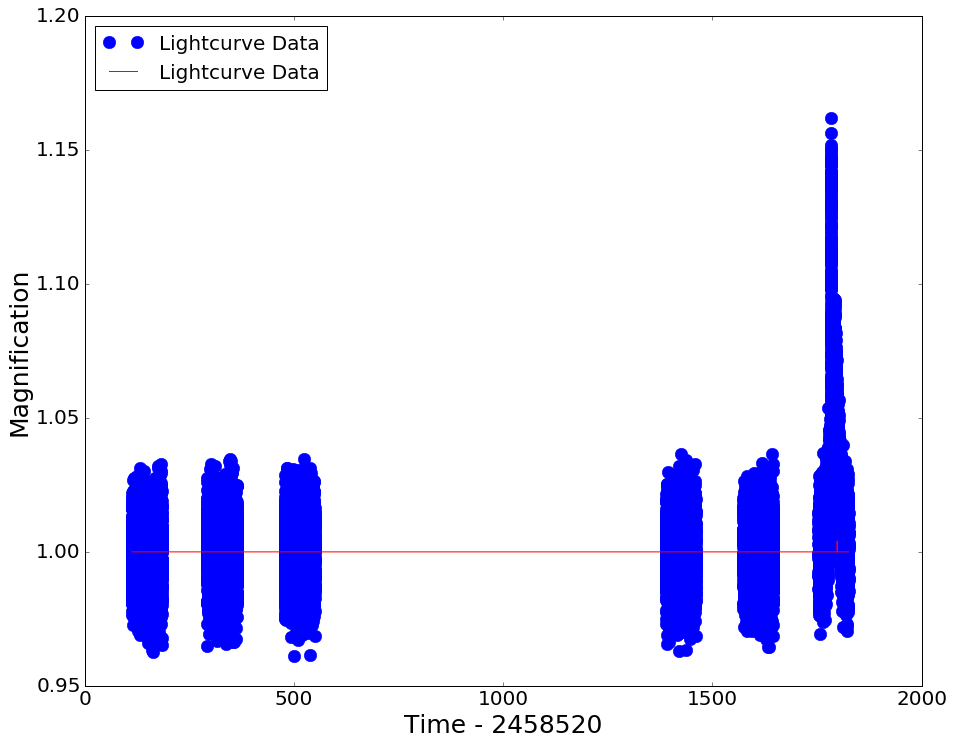

In [154]:
plt.plot(df['t']-2458234,df['A'],'b.', markersize=25, label='Lightcurve Data')
plt.plot(df['t']-2458234,PSPL_Gaussian(result2.params['t0'].value,result2.params['tE'].value,result2.params['u0'].value,
         result2.params['tp'].value,result2.params['tEp'].value,result2.params['amp'].value, df['t']),'r-', label='Lightcurve Data')
plt.ylabel('Magnification', size=25)
plt.xlabel('Time - 2458520', size=25)
#plt.xlim(400,550)
plt.legend(loc=2,fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


fig = plt.gcf()
fig.set_size_inches(15.0,12.0)
# plt.savefig('Chebyshevfit_success.png')